# Úkol č. 4 - regrese (do 12. května)

  * Cílem tohoto úkolu je vyzkoušet si řešit regresní problém na reálných (ale celkem vyčištěných) datech.
  
> **Nejdůležitější na úkolu je to, abyste udělali vše procesně správně: korektní rozdělení datasetu, ladění hyperparametrů, vyhodnocení výsledků atp.**

## Dataset

  * Zdrojem dat je list *Data* v souboru `Residential-Building-Data-Set.xlsx` na course pages (originál zde: https://archive.ics.uci.edu/ml/datasets/Residential+Building+Data+Set#).
  * Popis datasetu najdete na listu *Descriptions* ve stejném souboru.
  

## Pokyny k vypracování

  1. Rozdělte data na trénovací a testovací množinu.
  1. Proveďte základní průzkum dat a příp. vyhoďte nezajímavé příznaky.
  1. Aplikujte lineární a hřebenovou regresi a výsledky řádně vyhodnoťte:
    * K měření chyby použijte `mean_absolute_error`.
    * Experimentujte s tvorbou nových příznaků (na základě těch dostupných).
    * Experimentujte se standardizací/normalizací dat.
    * Vyberte si hyperparametry modelů k ladění a najděte jejich nejlepší hodnoty.
  1. Použijte i jiný model než jen lineární a hřebenovou regresi.


## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte pouze tento Jupyter Notebook, opravujíví by neměl nic jiného potřebovat.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = None  ## pro zobrazení všech sloupců
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation (so 0.000 is printed as 0.)

Načtení dat, kontrola přítomnosti null hodnot

In [2]:
data = pd.read_excel("Residential-Building-Data-Set.xlsx", sheet_name=0, header=[1])
data.isna().sum().sum()

0

In [3]:
data.head(1)

,START YEAR,START QUARTER,COMPLETION YEAR,COMPLETION QUARTER,V-1,V-2,V-3,V-4,V-5,V-6,V-7,V-8,V-11,V-12,V-13,V-14,V-15,V-16,V-17,V-18,V-19,V-20,V-21,V-22,V-23,V-24,V-25,V-26,V-27,V-28,V-29,V-11.1,V-12.1,V-13.1,V-14.1,V-15.1,V-16.1,V-17.1,V-18.1,V-19.1,V-20.1,V-21.1,V-22.1,V-23.1,V-24.1,V-25.1,V-26.1,V-27.1,V-28.1,V-29.1,V-11.2,V-12.2,V-13.2,V-14.2,V-15.2,V-16.2,V-17.2,V-18.2,V-19.2,V-20.2,V-21.2,V-22.2,V-23.2,V-24.2,V-25.2,V-26.2,V-27.2,V-28.2,V-29.2,V-11.3,V-12.3,V-13.3,V-14.3,V-15.3,V-16.3,V-17.3,V-18.3,V-19.3,V-20.3,V-21.3,V-22.3,V-23.3,V-24.3,V-25.3,V-26.3,V-27.3,V-28.3,V-29.3,V-11.4,V-12.4,V-13.4,V-14.4,V-15.4,V-16.4,V-17.4,V-18.4,V-19.4,V-20.4,V-21.4,V-22.4,V-23.4,V-24.4,V-25.4,V-26.4,V-27.4,V-28.4,V-29.4,V-9,V-10
0,81,1,85,1,1,3150.0,920.0,598.5,190,1010.84,16,1200,6713.0,56.2,61.52,6.11,320957.3,3485.8,64.5,239.5,12456.6,15,797.3,809.8,1755.0,8003.0,67.81,63.25,3758.77,42587.0,628132.9,4986.0,55.5,60.78,3.94,297210.1,3663.5,61.5,179.63,9342.45,15,757.8,861.8,1755.0,8018.0,65.0,60.53,3538.71,31940.25,610502.7,6788.0,54.2,59.4,5.41,280451.7,3755.8,58.1,119.75,6228.3,15,795.0,818.5,1755.0,8001.0,63.69,58.55,3347.72,21293.5,589389.6,5728.0,52.4,57.65,5.4,262789.0,2931.4,54.2,59.88,3114.15,15,746.8,815.5,1755.0,8013.0,62.78,56.45,3387.72,10646.75,606524.2,7196.0,51.3,56.13,5.97,249110.7,2562.3,52.8,217.0,10445.6,15,733.8,815.5,1755.0,8002.0,60.74,54.26,2978.26,41407.0,601988.1,2200,410


PF-7 je počet čtvrtí roku (year quarters) výstavby. Jelikož se dá V-7 vypočíst z prvních 4 sloupců (důkaz níže), jsou buď sloupce nebo V-7 nadbytečné.

In [4]:
start = data['START YEAR'] + 0.25*data['START QUARTER']
completion = data['COMPLETION YEAR'] + 0.25*data['COMPLETION QUARTER']
quarters = ((completion - start)*4).astype('int64')
(quarters == data['V-7']).value_counts()

True    372
dtype: int64

Rok rok počátku/konce stavby může být ale i tak důležitž a to kvůli cenám v průběhu času, tak smažu pouze quarters.

In [5]:
data = data.drop(columns=['START QUARTER','COMPLETION QUARTER'])

Rozdělení na trénovací a testovací množinu

In [6]:
from sklearn.model_selection import train_test_split
X = data[data.columns[:-2]]
y = data[data.columns[-2:]] #posledni dva sloupecky
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)
print("Xtrain: ", Xtrain.shape, "\nXtest: ", Xtest.shape,"\nytrain: ", ytrain.shape,"\nytest: ", ytest.shape)

Xtrain:  (279, 105) 
Xtest:  (93, 105) 
ytrain:  (279, 2) 
ytest:  (93, 2)


## Funkce na výpis MAE, MAPE apod.

MAE převádím vydělením skutečnou hodnotou výstupu na MAPE (mean absolute percentage error) pro lepší představu o přesnosti odhadu.

In [7]:
from sklearn.metrics import mean_absolute_error

def get_error(ytrue, ypredicted):
    mae_raw = mean_absolute_error(y_true=ytrue, y_pred=ypredicted, multioutput='raw_values')
    mae_uni = mean_absolute_error(y_true=ytrue, y_pred=ypredicted, multioutput='uniform_average')
    print("Průměrná chyba odhadu V-9 (out_1): ",round((mae_raw[0]/ytrue['V-9'].mean()) * 100, 2), "%",
          "\tAbsolutní:", round(mae_raw[0], 2))
    print("Průměrná chyba odhadu V-10 (out_2): ",round((mae_raw[1]/ytrue['V-10'].mean()) * 100, 2), "%",
          "\tAbsolutní:", round(mae_raw[1], 2))
    print("Uniform average (průměr chyb odhadu y1 a y2):", round(mae_uni, 2))
    return {'mape_y1':round((mae_raw[0]/ytrue['V-9'].mean()) * 100,2),
            'mape_y2':round((mae_raw[1]/ytrue['V-10'].mean())* 100,2)}

### Ukládání MAE do slovníku pro vyhodnocení v Závěru

In [8]:
MAE_results = {}

Linearni regrese zvlada predpovidat vícenásobné target values.

## Bez feature selection:

#### Linear

In [9]:
#linear regression bez úpravy vstupu
from sklearn.linear_model import LinearRegression
#fit a predikce
lin_reg = LinearRegression()
lin_reg.fit(Xtrain, ytrain)
yhat = lin_reg.predict(Xtest)
#vyhodnocení chyby
mae_values = get_error(ytest, yhat)
MAE_results['linear, nothing else'] = mae_values

Průměrná chyba odhadu V-9 (out_1):  7.7 % 	Absolutní: 123.53
Průměrná chyba odhadu V-10 (out_2):  6.56 % 	Absolutní: 15.96
Uniform average (průměr chyb odhadu y1 a y2): 69.74


#### Ridge (+ vytvoření funkce)

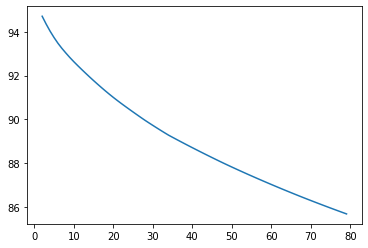

Optimal alpha 400.0
Průměrná chyba odhadu V-9 (out_1):  7.56 % 	Absolutní: 121.21
Průměrná chyba odhadu V-10 (out_2):  7.04 % 	Absolutní: 17.13
Uniform average (průměr chyb odhadu y1 a y2): 69.17


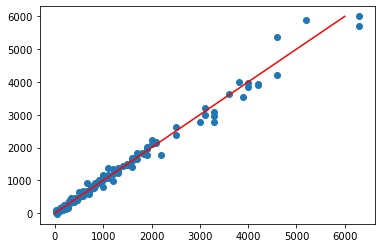

In [10]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from scipy import optimize

def get_ridge_model(X, Y):
    def ridgemodel(alpha):
        clf = Ridge(alpha=alpha)
        return -np.mean(cross_val_score(clf, X, Y, cv=5, scoring='neg_mean_absolute_error'))
    alphas = range(2,80)
    alpha_results = [ridgemodel(alpha) for alpha in alphas]
    plt.plot(alphas, alpha_results)
    plt.show()
    # Find Ridge alpha automatically
    opt_alpha = optimize.minimize_scalar(ridgemodel, options = {'maxiter': 30}, method = 'bounded', bounds=(0.1, 400))
    print('Optimal alpha', round(opt_alpha.x,2))
    model = Ridge(alpha = opt_alpha.x)
    model.fit(X,Y)
    return model
    
model = get_ridge_model(Xtrain, ytrain)

yhat = model.predict(Xtest)
plt.scatter(ytest, yhat)
plt.plot([0,6000], [0,6000], 'r')

mae_values = get_error(ytest, yhat)
MAE_results['ridge, nothing else'] = mae_values

Tady je vidět, že hodnota alfa nemá moc smysl - zasekla se prostě na bounds, které jsme dali funkci, která má hledat její optimální hodnotu.
Hezký komentář zde - porovnání s lasso regresí, kterou zde budu na zkoušku také používat: https://www.youtube.com/watch?v=NGf0voTMlcs (STATQUEST! BAM!)

## S feature selection:
#### Hledání nejlepšího K (užití validační množiny)

In [11]:
from sklearn.feature_selection import SelectKBest, f_regression

def find_kbest_k(Xtrain,ytrain,k_dict):
    ks = range(2,50,2)
    for k in ks:
        kb = SelectKBest(score_func=f_regression, k=k)
        # y1 (1. sloupec výstupu)
        kb.fit(Xtrain, ytrain.iloc[:,0])
        k1 = kb.get_support(indices=True) #celkem mam 105 sloupcu priznaku, vypise indexy vybranych priznaku
        # y2
        kb.fit(Xtrain, ytrain.iloc[:,1])
        k2 = kb.get_support(indices=True) #celkem mam 105 sloupcu priznaku, vypise indexy vybranych priznaku
        # sjednocení dvou polí - indexy sloupců příznaků pro y1 a y2
        k_joined = np.union1d(k1, k2) 
        
        # omezím Xtrain jen na vybrané sloupce K příznaků
        Xtrain_new = Xtrain.iloc[:,k_joined]
                        
        #lin regrese - kvůli score dělám zvlášť y1 (sloupec V-9) a y2 (sloupec V-10)
        lin_regressor = LinearRegression()
        # y1
        n_mae_1 = cross_val_score(lin_regressor,Xtrain_new,ytrain.iloc[:,0],scoring='neg_mean_absolute_error',cv=5)
        mean_nmae1 = -np.mean(n_mae_1)
        # y2
        n_mae_2 = cross_val_score(lin_regressor,Xtrain_new,ytrain.iloc[:,1],scoring='neg_mean_absolute_error',cv=5)
        mean_nmae2 = -np.mean(n_mae_2)
        
        # values slovníku pro K: [počet_nejlepších_příznaků_pro_y1_y2, MAE_pro_y1, MAE_pro_y2, indexy příznaků]
        k_dict[k] = [len(k_joined), round(mean_nmae1,2),round(mean_nmae2,2), k_joined]

#### Vizualizace pro určení vhodného K

In [12]:
k_dict={}
find_kbest_k(Xtrain,ytrain,k_dict)
# vytvořím seznamy hodnot K, a MAE pro y1 a y2
k = [i for i in k_dict]
y1 = [i[1] for i in k_dict.values()]
y2 = [i[2] for i in k_dict.values()]

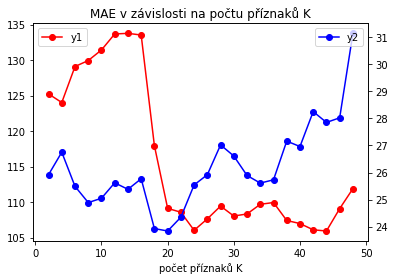

In [13]:
figure, axis_1 = plt.subplots()
axis_1.plot(k, y1, '-o', color='r',label='y1')
axis_2 = axis_1.twinx()
axis_2.plot(k,y2, '-o', color='b',label='y2')
plt.title('MAE v závislosti na počtu příznaků K')
axis_1.set_xlabel('počet příznaků K')
axis_1.legend(loc="upper left")
axis_2.legend(loc="upper right")
plt.show()

Pro oba dohromady se zdá být nejlepší K=20 příznaků.

"After a CV, we normally fit to the whole training set - we don't select the CV fold data which had the best performance."
https://stackoverflow.com/questions/56129726/fitting-model-when-using-cross-validation-to-evaluate-performance

Určíme mean absolute error predikce určené za pomoci modelu nafitovaného na datech s K (K=20) vybranými příznaky.
Nejprve vytvoříme dataset z původních trénovacích dat - omezíme na vybrané příznaky.

In [14]:
#indexy příznaků sjednocené pro y1 a y2 (do SelectKBest jsme zadali 20, ale celkem bude po sjednocení 24 příznaků)
K = k_dict[20][3]
#tvorba nového datasetu - trénovacího i testovacího
Xtrain_K =  Xtrain.iloc[:,K]
Xtest_K = Xtest.iloc[:,K]
print("Počet příznaků celkem: ",len(K))

Počet příznaků celkem:  24


Lineární regrese

In [15]:
lin_regressor = LinearRegression()
lin_regressor.fit(Xtrain_K, ytrain)
yhat = lin_regressor.predict(Xtest_K)
#kvalita modelu
mae_values = get_error(ytest, yhat)
MAE_results['linear, KBest'] = mae_values

Průměrná chyba odhadu V-9 (out_1):  8.88 % 	Absolutní: 142.39
Průměrná chyba odhadu V-10 (out_2):  8.64 % 	Absolutní: 21.03
Uniform average (průměr chyb odhadu y1 a y2): 81.71


Hřebenová regrese

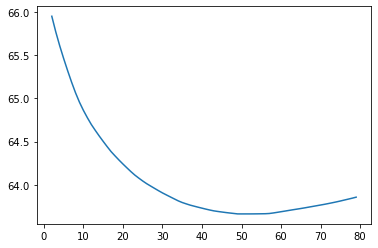

Optimal alpha 51.71


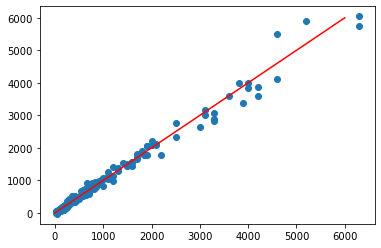

Průměrná chyba odhadu V-9 (out_1):  8.77 % 	Absolutní: 140.65
Průměrná chyba odhadu V-10 (out_2):  9.17 % 	Absolutní: 22.32
Uniform average (průměr chyb odhadu y1 a y2): 81.48


In [16]:
model = get_ridge_model(Xtrain_K, ytrain)
yhat = model.predict(Xtest_K)
plt.scatter(ytest, yhat)
plt.plot([0,6000], [0,6000], 'r')
plt.show()
#kvalita modelu
mae_values = get_error(ytest, yhat)
MAE_results['ridge, KBest'] = mae_values

## Standardizační okénko

https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia

"when using penalization methods such as ridge regression or lasso the result is no longer invariant to standardization. It is, however, often recommended to standardize" -> další komentář v závěru

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Xtrain)
X2_train = pd.DataFrame(scaler.transform(Xtrain), columns=Xtrain.columns)
X2_test = pd.DataFrame(scaler.transform(Xtest), columns=Xtest.columns)

In [18]:
# zadávám K=20, určeno výše
kb = SelectKBest(score_func=f_regression, k=20)

# out_1
kb.fit(X2_train, ytrain.iloc[:,0])
k1 = kb.get_support(indices=True) #celkem mam 105 sloupcu priznaku, vypise indexy vybranych priznaku
# out_2
kb.fit(X2_train, ytrain.iloc[:,1])
k2 = kb.get_support(indices=True) #celkem mam 105 sloupcu priznaku, vypise indexy vybranych priznaku

# sjednocení dvou polí - indexy sloupců příznaků pro out_1 a out_2
k_joined = np.union1d(k1, k2) 

# vytvořím nový dataframe z příznaků, které byly vhodné pro oba (sjednocením) - a co zkusit průnik?
Xtrain_new = X2_train.iloc[:,k_joined]
# i pro testovací data
Xtest_new = X2_test.iloc[:,k_joined]

### Se standardizovanými daty

Lineární regrese

In [19]:
#lin regrese
lin_regressor = LinearRegression()
lin_regressor.fit(Xtrain_new, ytrain)
yhat = lin_regressor.predict(Xtest_new)
#kvalita modelu
mae_values = get_error(ytest, yhat)
MAE_results['linear, KBest, standardized'] = mae_values

Průměrná chyba odhadu V-9 (out_1):  8.88 % 	Absolutní: 142.39
Průměrná chyba odhadu V-10 (out_2):  8.64 % 	Absolutní: 21.03
Uniform average (průměr chyb odhadu y1 a y2): 81.71


Hřebenová regrese

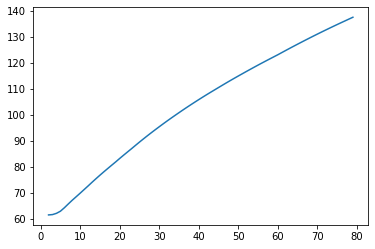

Optimal alpha 2.11


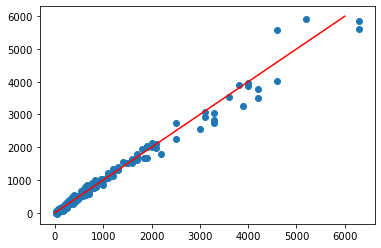

Průměrná chyba odhadu V-9 (out_1):  9.21 % 	Absolutní: 147.72
Průměrná chyba odhadu V-10 (out_2):  10.14 % 	Absolutní: 24.69
Uniform average (průměr chyb odhadu y1 a y2): 86.2


In [20]:
model = get_ridge_model(Xtrain_new, ytrain)
yhat = model.predict(Xtest_new)
plt.scatter(ytest, yhat)
plt.plot([0,6000], [0,6000], 'r')
plt.show()
#kvalita modelu
mae_values = get_error(ytest, yhat)
MAE_results['ridge, KBest, standardized'] = mae_values

## Lasso regression
Jelikož lasso regrese dokáže sama anulovat nezajímavé příznaky, vyzkouším predikce s i bez omezení příznaků pomocí SelectKBest.

In [21]:
from sklearn.linear_model import Lasso
from warnings import filterwarnings
filterwarnings('ignore') ## POTLAČUJI VÝPIS WARNINGS

In [22]:
def get_lasso_model(X, Y):
    def lassomodel(alpha):
        clf = Lasso(alpha=alpha)
        return -np.mean(cross_val_score(clf, X, Y, cv=5, scoring='neg_mean_absolute_error'))
    alphas = range(1,30)
    alpha_results = [lassomodel(alpha) for alpha in alphas]
    plt.plot(alphas, alpha_results)
    plt.show()
    # Find lasso alpha automatically
    opt_alpha = optimize.minimize_scalar(lassomodel, options = {'maxiter': 30}, method = 'bounded', bounds=(0.1, 30))
    print('Optimal alpha', round(opt_alpha.x,2))
    model = Lasso(alpha = opt_alpha.x)
    model.fit(X,Y)
    return model

Nejprve tedy s nezměněným datasetem

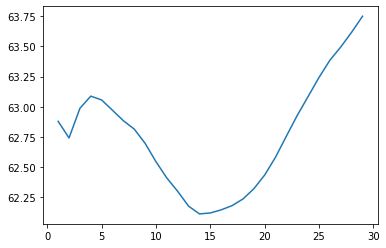

Optimal alpha 14.18
Průměrná chyba odhadu V-9 (out_1):  7.53 % 	Absolutní: 120.72
Průměrná chyba odhadu V-10 (out_2):  7.07 % 	Absolutní: 17.2
Uniform average (průměr chyb odhadu y1 a y2): 68.96


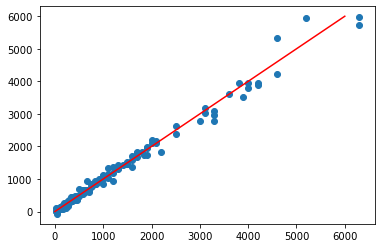

In [23]:
model = get_lasso_model(Xtrain, ytrain)
yhat = model.predict(Xtest)
plt.scatter(ytest, yhat)
plt.plot([0,6000], [0,6000], 'r')
mae_values = get_error(ytest, yhat)
MAE_results['lasso, nothing else'] = mae_values

S vybranými K features (K=20)

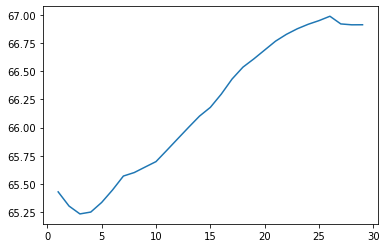

Optimal alpha 3.06
Průměrná chyba odhadu V-9 (out_1):  8.45 % 	Absolutní: 135.47
Průměrná chyba odhadu V-10 (out_2):  9.57 % 	Absolutní: 23.29
Uniform average (průměr chyb odhadu y1 a y2): 79.38


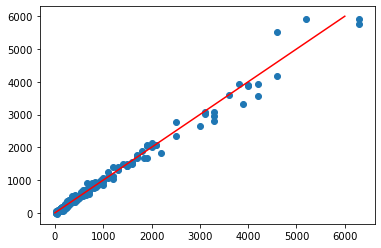

In [24]:
model = get_lasso_model(Xtrain_K, ytrain)
yhat = model.predict(Xtest_K)
plt.scatter(ytest, yhat)
plt.plot([0,6000], [0,6000], 'r')
mae_values = get_error(ytest, yhat)
MAE_results['lasso, KBest'] = mae_values

Se standardizovanými daty a vybranými K=20 příznaky

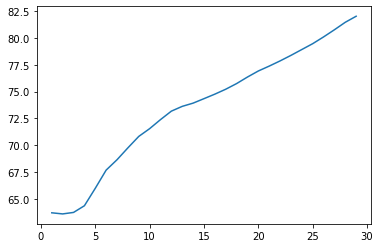

Optimal alpha 1.58
Průměrná chyba odhadu V-9 (out_1):  8.96 % 	Absolutní: 143.77
Průměrná chyba odhadu V-10 (out_2):  13.24 % 	Absolutní: 32.22
Uniform average (průměr chyb odhadu y1 a y2): 87.99


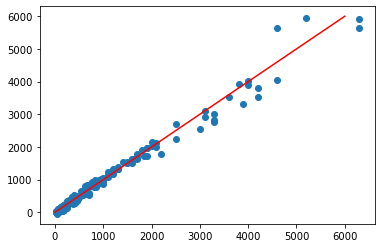

In [25]:
model = get_lasso_model(Xtrain_new, ytrain)
yhat = model.predict(Xtest_new)
plt.scatter(ytest, yhat)
plt.plot([0,6000], [0,6000], 'r')
mae_values = get_error(ytest, yhat)
MAE_results['lasso, KBest, standardized'] = mae_values

## Závěr

Vyzkoušela jsem tvorbu modelů pomocí **lineární, hřebenové a lasso regrese**. Tyto modely jsem aplikovala na prakticky nezměněná data, na data omezená na K vybraných příznaků a jako třetí variantu jsem zkoušela model na datech s K vybranými příznaky, které byly navíc standardizované.

Výsledky jsem vyhodnocovala podle **mean absolute error**, který jsem pro lepší představu **převedla** vydělením průměrnou hodnotou skutečného výstupu na **mean absolute percentage error**.

**Cílem bylo natrénovat model, který by co nejlépe predikoval obě výstupní proměnné (V-9 a V-10) najednou.**

Všechny výše uvedené typy regresí poskytují v balíčku scikit learn možnost pracovat s **vícenásobným výstupem**.

Na **problém s vícenásobným výstupem** jsem narazila při použití **SelectKBest**, který tuto možnost nepodporuje. Pro určení nejlepšího K jsem tedy **postupovala pro každý výstup zvlášť**, vyplotila si pro každé K MAE získané cross-validací na trénovací množině také pro každý výstup zvlášť a podle toho určila společný nejlepší počet příznaků.

**Hledání společných příznaků** jsem vyřešila tak, že pro každé z y1 a y2 jsem sjednotila příznaky vhodné pro oba. Takže **například**: pokud jsem zadala do SelectKBest K=10, pak jsem hledala zvlášť 10 nejvhodnějších příznaků pro y1 a to samé pro y2. Poté, co jsem získala indexy těchto příznaků, jsem provedla jejich sjednocení a zobrazila si, kolik příznaků je v této sjednocené množině. Takže výsledek mohl být například F = 12, protože příznaky se pro y1 a y2 lišily jen o 2. Protože se **konečný počet příznaků** F od **původního K** při vypracovávání tohoto úkolu nelišil o mnoho, vyhodnotila jsem tento postup jako pro tuto úlohu vhodný.

Výpis procentuelního MAE na testovací množině mape_y1 je MAPE pro výstup y1 (V-9), mape_y2 pro výstup y2 (V-10) a y_avg je průměr obou těchto odchylek.

In [26]:
ks, y1, y2 = [],[],[]
for k,v in MAE_results.items():
    ks.append(k)
    y1.append(list(v.values())[0])
    y2.append(list(v.values())[1])
errors = pd.DataFrame([ks,y1,y2]).T
errors.columns=['metoda','mape_y1','mape_y2']
errors['y_avg'] = (errors['mape_y1']+errors['mape_y2'])/2
errors.sort_values(by=['y_avg'])

,metoda,mape_y1,mape_y2,y_avg
0,"linear, nothing else",7.7,6.56,7.13
1,"ridge, nothing else",7.56,7.04,7.3
6,"lasso, nothing else",7.53,7.07,7.3
2,"linear, KBest",8.88,8.64,8.76
4,"linear, KBest, standardized",8.88,8.64,8.76
3,"ridge, KBest",8.77,9.17,8.97
7,"lasso, KBest",8.45,9.57,9.01
5,"ridge, KBest, standardized",9.21,10.14,9.675
8,"lasso, KBest, standardized",8.96,13.24,11.1


Při pohledu na tabulku, která byla **seřazena vzestupně podle průměrného procentuálního MAE**, je možno pozorovat několik věcí.

Nejlépe si vedou regrese aplikované na nijak neupravená data. 

**Proč tedy používat feature selection?** Je dobré se podívat na to, **o kolik horší jsou výsledky** získané na datasetech, které prošly **výraznou redukcí** příznaků. Původních příznaků bylo 105, po užití KBest selekce jsme data omezili na 24 příznaků.

Jako další v pořadí se v tabulce umístila **lineární regrese na datech s K příznaky** a na datech s K standardizovanými příznaky. Výsledky pro tyto obě varianty byly identické. Je vidět, že se průměrné MAPE liší o méně než dvě procenta, což je stále dobrý výsledek.

Dále se se vcelku podobnými výsledky umístila **hřebenová a lasso regrese s K vybranými příznaky**. Standardizace v tomto případě pravděpodobně vhodná není, jak je vidět z pozic, které tyto možnosti v tabulce zaujaly.

Pokud tedy chceme pracovat pouze s K nejlepšími příznaky, je v našem případě zřejmě nejlepší užít **lineární regresi**, ovšem od hřebenové a lasso regrese se výsledky výrazně neliší (rozdíl mezi linear, Kbest a lasso, Kbest je **sotva 0.05 %**).